In [73]:
import csv
import time
import os
import random
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import optuna

train_ratio = 0.8
optuna_optimisation = False
# optuna_optimisation = True

external_data_path = "../data/external/"
image_path = "images/"

In [74]:
# --- Data Preprocessing (Unchanged) ---
# This function is efficient and does not need changes.
def preprocess_ratings(data):
    """Converts a list of lists of ratings into a flattened COO-like format."""
    all_x, all_y, all_r = [], [], []
    ptrs = [0]
    for i, ratings in enumerate(data):
        for j, r in ratings:
            all_x.append(i)
            all_y.append(j)
            all_r.append(r)
        ptrs.append(len(all_r))
    return (
        np.array(all_x, dtype=np.int32),
        np.array(all_y, dtype=np.int32),
        np.array(all_r, dtype=np.float64),
        np.array(ptrs, dtype=np.int32)
    )

In [75]:
folder_name = external_data_path + "ml-32m"
file_name = "ratings.csv" 
file_path = os.path.join(folder_name, file_name)

In [76]:
min_ratings_per_movie = 50

# User and movie mappings
user_to_idx = {}
idx_to_user = {}
movie_to_idx = {}
idx_to_movie = {}

# Sparse Lists for user and movie ratings
user_ratings_train = []
user_ratings_test = []
movie_ratings_train = []
movie_ratings_test = []

test_count = 0
train_count = 0
start_time = time.time()

# First pass: count movie ratings
movie_rating_counts = {}

try:
    with open(file_path, 'r', newline='', encoding='utf-8') as csvfile:
        csv_reader = csv.reader(csvfile)
        header = next(csv_reader)
        for row in csv_reader:
            movie_id = row[1]
            movie_rating_counts[movie_id] = movie_rating_counts.get(movie_id, 0) + 1
except FileNotFoundError:
    print(f"File {file_path} not found.")
except Exception as e:
    print(f"An error occurred during first pass: {e}")

# Filter movies by rating count
valid_movies = {movie_id for movie_id, count in movie_rating_counts.items() if count >= min_ratings_per_movie}

# Second pass: process ratings
try:
    with open(file_path, 'r', newline='', encoding='utf-8') as csvfile:
        csv_reader = csv.reader(csvfile)
        header = next(csv_reader)
        for row in csv_reader:
            user_id = row[0]
            movie_id = row[1]
            rating = float(row[2])

            if movie_id not in valid_movies:
                continue  # Skip movies with too few ratings

            if user_id not in user_to_idx:
                user_idx = len(user_to_idx)
                user_to_idx[user_id] = user_idx
                idx_to_user[user_idx] = user_id
                user_ratings_train.append([])
                user_ratings_test.append([])

            if movie_id not in movie_to_idx:
                movie_idx = len(movie_to_idx)
                movie_to_idx[movie_id] = movie_idx
                idx_to_movie[movie_idx] = movie_id
                movie_ratings_train.append([])
                movie_ratings_test.append([])

            user_idx = user_to_idx[user_id]
            movie_idx = movie_to_idx[movie_id]

            user_seen_before = len(user_ratings_train[user_idx]) > 0
            movie_seen_before = len(movie_ratings_train[movie_idx]) > 0

            if not user_seen_before or not movie_seen_before or random.random() < train_ratio:
                # Assign to training set
                user_ratings_train[user_idx].append((movie_idx, rating))
                movie_ratings_train[movie_idx].append((user_idx, rating))
                train_count += 1
            else:
                # Assign to test set (only if both user and movie are known from training)
                user_ratings_test[user_idx].append((movie_idx, rating))
                movie_ratings_test[movie_idx].append((user_idx, rating))
                test_count += 1

except FileNotFoundError:
    print(f"File {file_path} not found.")
except Exception as e:
    print(f"An error occurred during second pass: {e}")

end_time = time.time()

# --- Logging ---
print("Finished")
print("Time taken:", round(end_time - start_time, 2), "seconds")
print("Train Count:", train_count)
print("Test Count:", test_count)
print("Unique Users:", len(user_to_idx))
print("Valid Movies (after filter):", len(movie_to_idx))


Finished
Time taken: 89.93 seconds
Train Count: 25240945
Test Count: 6257744
Unique Users: 200947
Valid Movies (after filter): 16034


In [77]:
all_u_train, all_m_train, all_r_train_u, user_ptrs_train = preprocess_ratings(user_ratings_train)
all_m_rev_train, all_u_rev_train, all_r_train_m, item_ptrs_train = preprocess_ratings(movie_ratings_train)
all_u_test, all_m_test, all_r_test, user_ptrs_test = preprocess_ratings(user_ratings_test)

num_users = len(user_ratings_train)
num_items = len(movie_ratings_train)

ratings_mean = np.mean(all_r_train_u)

In [78]:
file_name = "movies.csv" 
file_path = os.path.join(folder_name, file_name)

movie_id_to_movie_name = {}
movie_name_to_movie_id = {}

try:
    with open(file_path, 'r', newline='', encoding='utf-8') as csvfile:
        csv_reader = csv.reader(csvfile)
        header = next(csv_reader)
        for row in csv_reader:
            movie_id = row[0]
            movie_name = row[1]

            if movie_id not in movie_id_to_movie_name:
                movie_id_to_movie_name[movie_id] = movie_name
                movie_name_to_movie_id[movie_name] = movie_id

except FileNotFoundError:
    print(f"File {file_path} not found.")
except Exception as e:
    print(f"An error occurred: {e}")

In [79]:
genre_to_idx = {}
idx_to_genre = {}
item_features = np.zeros((num_items, 0))  # Temporary shape, will resize after discovering genres

try:
    with open(file_path, 'r', newline='', encoding='utf-8') as csvfile:
        csv_reader = csv.reader(csvfile)
        header = next(csv_reader)
        temp_genre_data = [[] for _ in range(num_items)]

        for row in csv_reader:
            movie_id, movie_name, genres = row[0], row[1], row[2]

            if movie_id not in movie_to_idx:
                continue  # Ignore movies filtered out earlier

            movie_idx = movie_to_idx[movie_id]
            genre_list = genres.split('|')

            for genre in genre_list:
                if genre not in genre_to_idx:
                    idx = len(genre_to_idx)
                    genre_to_idx[genre] = idx
                    idx_to_genre[idx] = genre

                temp_genre_data[movie_idx].append(genre_to_idx[genre])

except FileNotFoundError:
    print(f"File {file_path} not found.")
except Exception as e:
    print(f"An error occurred while parsing genres: {e}")

# --- Step 2: Create one-hot genre matrix ---
num_genres = len(genre_to_idx)
item_features = np.zeros((num_items, num_genres), dtype=np.float32)

for movie_idx, genre_indices in enumerate(temp_genre_data):
    for genre_idx in genre_indices:
        item_features[movie_idx, genre_idx] = 1.0

num_features = num_genres

In [80]:
import numpy as np
from numba import njit, prange

# --- OPTIMIZED Numba-Accelerated Updates (Parallel) ---
@njit(parallel=True, cache=True)
def update_user_embeddings(num_users, user_ptrs, all_m, all_r,
                           user_embeddings, item_embeddings,
                           user_biases, item_biases,
                           lam, gamma, tau_identity):
    """
    Update user embeddings in parallel using the pre-calculated item embeddings.
    """
    dim = user_embeddings.shape[1]
    # This loop now runs in parallel across all available CPU cores
    for u in prange(num_users):
        start = user_ptrs[u]
        end = user_ptrs[u+1]
        n = end - start
        if n == 0:
            continue
            
        # Use fancy indexing to grab all necessary data at once
        movies = all_m[start:end]
        ratings = all_r[start:end]
        item_vecs = item_embeddings[movies]
        item_bias = item_biases[movies]
    
        # Perform vectorized prediction
        preds = item_vecs @ user_embeddings[u] + item_bias
        
        residuals = ratings - preds
        user_bias = lam * np.sum(residuals) / (lam * n + gamma)
        user_biases[u] = user_bias
    
        # Solve for the new embedding
        adjusted = ratings - user_bias - item_bias
        A = lam * (item_vecs.T @ item_vecs) + tau_identity
        b = lam * (item_vecs.T @ adjusted)
        user_embeddings[u] = np.linalg.solve(A, b)

@njit(parallel=True, cache=True)
def update_item_embeddings(num_items, item_ptrs, all_u, all_r,
                           user_embeddings, item_embeddings,
                           user_biases, item_biases,
                           item_features, feature_embeddings,
                           lam, gamma, tau, tau_identity):
    """
    Update item embeddings in parallel using the pre-calculated user embeddings.
    """
    dim = item_embeddings.shape[1]
    
    for m in prange(num_items):
        start = item_ptrs[m]
        end = item_ptrs[m+1]
        n = end - start
        if n == 0:
            continue
            
        users = all_u[start:end]
        ratings = all_r[start:end]
        user_vecs = user_embeddings[users]
        user_bias = user_biases[users]

        preds = user_vecs @ item_embeddings[m] + user_bias
        residuals = ratings - preds

        item_bias = lam * np.sum(residuals) / (lam * n + gamma)
        item_biases[m] = item_bias

        adjusted = ratings - user_bias - item_bias
        A = lam * (user_vecs.T @ user_vecs) + tau_identity
        b = lam * (user_vecs.T @ adjusted)

        # FEATURE TERM
        active_features = item_features[m]  # 1D binary vector (float64)
        feature_sum = active_features @ feature_embeddings  # shape: (dim,)
        num_active = np.sum(active_features)

        if num_active > 0.0:
            tau_feature_term = (tau / np.sqrt(num_active)) * feature_sum
        else:
            tau_feature_term = np.zeros(dim, dtype=np.float64)

        b += tau_feature_term
        item_embeddings[m] = np.linalg.solve(A, b)


def update_feature_embeddings(item_embeddings, item_features, feature_embeddings):
    """
    Updates feature embeddings (e.g., genres) based on item embeddings.

    Args:
        item_embeddings: [num_items, dim]
        item_features: [num_items, num_features] binary (0 or 1)
        feature_embeddings: [num_features, dim]

    Returns:
        Updated feature_embeddings in-place.
    """
    num_items, dim = item_embeddings.shape
    num_features = feature_embeddings.shape[0]

    for l in range(num_features):
        numer = np.zeros(dim)
        denom = 0.0

        for n in range(num_items):
            if item_features[n, l] == 0:
                continue

            F_n = np.sum(item_features[n])
            if F_n == 0:
                continue

            v_n = item_embeddings[n]
            f_sum = np.sum(feature_embeddings[item_features[n] == 1], axis=0)
            f_excl = f_sum - feature_embeddings[l]

            contrib = v_n / np.sqrt(F_n) - f_excl / F_n
            numer += contrib
            denom += 1.0 / F_n

        feature_embeddings[l] = numer / (denom + 1.0)


# --- OPTIMIZED JIT-compiled evaluation function (Parallel) ---
@njit(parallel=True, cache=True)
def calculate_rmse_jit(ptrs, all_user_indices, all_item_indices, all_ratings, 
                       user_embeddings, item_embeddings, user_biases, item_biases):
    """
    Calculates the Root Mean Squared Error in parallel.
    This function is generic and processes the data from a user-centric view.
    """
    total_squared_error = 0.0
    
    # Loop over all users in parallel
    for u in prange(len(ptrs) - 1):
        start, end = ptrs[u], ptrs[u+1]
        if start == end:
            continue
            
        item_idxs = all_item_indices[start:end]
        actuals = all_ratings[start:end]
        
        # Vectorized prediction for all items rated by this user
        preds = (user_embeddings[u] @ item_embeddings[item_idxs].T) + user_biases[u] + item_biases[item_idxs]
        
        # Numba automatically handles thread-safe summation for reduction operations
        total_squared_error += np.sum((actuals - preds) ** 2)

    return np.sqrt(total_squared_error / len(all_ratings))

# --- OPTIMIZED Main Training Function ---
def training_als_from_preprocessed(
    mu, 
    num_users, num_items, num_features,
    item_features,
    all_u_train, all_m_train, all_r_train_u, user_ptrs_train,
    all_m_rev_train, all_u_rev_train, all_r_train_m, item_ptrs_train,
    all_u_test, all_m_test, all_r_test, user_ptrs_test,
    num_epochs=20, lam=0.1, gamma=0.1, tau=0.1,
    embeddings_dim=20, scale=0.1
):
    """
    Optimized ALS training using preprocessed data.
    """
    print("Starting ALS optimization (preprocessed)...")
    start_time = time.time()

    user_embeddings = np.random.normal(0, scale, (num_users, embeddings_dim)).astype(np.float64)
    item_embeddings = np.random.normal(0, scale, (num_items, embeddings_dim)).astype(np.float64)
    feature_embeddings = np.random.normal(0, scale, (num_features, embeddings_dim)).astype(np.float64)
    user_biases = np.zeros(num_users, dtype=np.float64)
    item_biases = np.zeros(num_items, dtype=np.float64)
    tau_identity = np.ascontiguousarray(tau * np.eye(embeddings_dim, dtype=np.float64))

    training_RMSE, testing_RMSE = [], []

    for epoch in range(num_epochs):
        epoch_start = time.time()

        update_user_embeddings(num_users, user_ptrs_train, all_m_train, all_r_train_u,
                               user_embeddings, item_embeddings,
                               user_biases, item_biases,
                               lam, gamma, tau_identity)

        update_item_embeddings(num_items, item_ptrs_train, all_u_rev_train, all_r_train_m,
                               user_embeddings, item_embeddings,
                               user_biases, item_biases,
                               np.array(item_features).astype(np.float64), feature_embeddings,  
                               lam, gamma, tau, tau_identity)
        
        update_feature_embeddings(item_embeddings, item_features, feature_embeddings)

        train_rmse = calculate_rmse_jit(user_ptrs_train, all_u_train, all_m_train, all_r_train_u,
                                        user_embeddings, item_embeddings,
                                        user_biases, item_biases)

        test_rmse = calculate_rmse_jit(user_ptrs_test, all_u_test, all_m_test, all_r_test,
                                       user_embeddings, item_embeddings,
                                       user_biases, item_biases)

        training_RMSE.append(train_rmse)
        testing_RMSE.append(test_rmse)

        print(f"Epoch {epoch+1}/{num_epochs} | Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f} | Time: {time.time() - epoch_start:.2f}s")

    print(f"Finished training. Total time: {time.time() - start_time:.2f}s")

    return training_RMSE, testing_RMSE, [user_embeddings, item_embeddings, feature_embeddings], [user_biases, item_biases]

In [81]:
lam = 0.1
gamma = 0.1
tau = 1
embeddings_dim = 10
scale = 1/embeddings_dim

In [82]:
num_epochs = 30

training_RMSE, testing_RMSE, embeddings, biases = training_als_from_preprocessed(
        ratings_mean,
        num_users, num_items, num_features,
        item_features,
        all_u_train, all_m_train, all_r_train_u, user_ptrs_train,
        all_m_rev_train, all_u_rev_train, all_r_train_m, item_ptrs_train,
        all_u_test, all_m_test, all_r_test, user_ptrs_test,
        num_epochs=num_epochs, lam=lam, gamma=gamma, tau=tau,
        embeddings_dim=embeddings_dim, scale=scale
    )

user_embeddings = embeddings[0]
item_embeddings = embeddings[1]
feature_embeddings = embeddings[2]

user_bias = biases[0]
item_bias = biases[1]

Starting ALS optimization (preprocessed)...
Epoch 1/30 | Train RMSE: 0.8383 | Test RMSE: 0.8727 | Time: 2.46s
Epoch 2/30 | Train RMSE: 0.7655 | Test RMSE: 0.8237 | Time: 2.16s
Epoch 3/30 | Train RMSE: 0.7383 | Test RMSE: 0.7988 | Time: 2.03s
Epoch 4/30 | Train RMSE: 0.7261 | Test RMSE: 0.7876 | Time: 1.99s
Epoch 5/30 | Train RMSE: 0.7201 | Test RMSE: 0.7823 | Time: 1.98s
Epoch 6/30 | Train RMSE: 0.7167 | Test RMSE: 0.7795 | Time: 2.03s
Epoch 7/30 | Train RMSE: 0.7148 | Test RMSE: 0.7780 | Time: 2.08s
Epoch 8/30 | Train RMSE: 0.7136 | Test RMSE: 0.7772 | Time: 2.44s
Epoch 9/30 | Train RMSE: 0.7128 | Test RMSE: 0.7769 | Time: 2.04s
Epoch 10/30 | Train RMSE: 0.7123 | Test RMSE: 0.7767 | Time: 2.05s
Epoch 11/30 | Train RMSE: 0.7120 | Test RMSE: 0.7766 | Time: 2.07s
Epoch 12/30 | Train RMSE: 0.7117 | Test RMSE: 0.7766 | Time: 2.05s
Epoch 13/30 | Train RMSE: 0.7115 | Test RMSE: 0.7766 | Time: 2.41s
Epoch 14/30 | Train RMSE: 0.7114 | Test RMSE: 0.7767 | Time: 2.07s
Epoch 15/30 | Train RMSE: 0

In [83]:
print(np.linalg.norm(user_embeddings, axis=1))
# Compute L2 norm of each movie's embedding vector
movie_norms = np.linalg.norm(item_embeddings, axis=1)

# Get top 10 movie indices with highest norms
top_10_indices = np.argsort(-movie_norms)[:10]  # descending sort
top_10_values = movie_norms[top_10_indices]

# If you want both as a list of (index, value) pairs:
top_10_pairs = list(zip(top_10_indices, top_10_values))

for index, value in top_10_pairs:
    print(f"Movie: {movie_id_to_movie_name[idx_to_movie[index]]}, Norm: {value:.4f}")

[0.77204625 0.71038883 0.57011487 ... 0.45805694 0.37730568 0.52741665]
Movie: Dumb & Dumber (Dumb and Dumber) (1994), Norm: 7.1974
Movie: Star Wars: Episode II - Attack of the Clones (2002), Norm: 6.8064
Movie: Natural Born Killers (1994), Norm: 6.7869
Movie: Lord of the Rings: The Return of the King, The (2003), Norm: 6.7363
Movie: Lord of the Rings: The Two Towers, The (2002), Norm: 6.6818
Movie: Lord of the Rings: The Fellowship of the Ring, The (2001), Norm: 6.6721
Movie: Twilight (2008), Norm: 6.5399
Movie: Ace Ventura: Pet Detective (1994), Norm: 6.4742
Movie: Star Wars: Episode I - The Phantom Menace (1999), Norm: 6.4377
Movie: Star Wars: Episode III - Revenge of the Sith (2005), Norm: 6.4263


In [84]:
user_id = "dummy_user"
movie_id = "1"
rating = 5

user_idx = len(user_to_idx)
user_to_idx[user_id] = user_idx
idx_to_user[user_idx] = user_id
movie = movie_to_idx[movie_id]

In [85]:
num_epochs = 100

dummy_user_embedding = np.random.normal(0, scale, embeddings_dim)
dummy_user_bias = 0
movie_embedding = item_embeddings[movie]
movie_bias = item_bias[movie]

tau_identity = tau * np.eye(embeddings_dim)

training_loss, training_RMSE, testing_RMSE = [], [], []

for epoch in range(num_epochs):
    actual_rating = rating
    pred = (dummy_user_embedding @ movie_embedding) + dummy_user_bias + movie_bias
    residual = actual_rating - pred

    dummy_user_bias = lam * residual / ((lam * 1) + gamma)

    adjusted_residual = actual_rating - dummy_user_bias - movie_bias
    user_inverse_term = lam * np.outer(movie_embedding, movie_embedding) + tau_identity
    user_term = lam * (movie_embedding * adjusted_residual)

    dummy_user_embedding = np.linalg.solve(user_inverse_term, user_term)

    pred = (dummy_user_embedding @ movie_embedding) + dummy_user_bias + movie_bias
    train_error = actual_rating - pred
    train_loss = (lam * train_error ** 2) \
        + (gamma * (np.sum(dummy_user_bias ** 2) + np.sum(item_bias[movie] ** 2))) \
        + (tau * (np.sum(dummy_user_embedding ** 2) + np.sum(item_embeddings[movie] ** 2)))


    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}")

Epoch 1/100, Loss: 20.4339
Epoch 2/100, Loss: 20.3293
Epoch 3/100, Loss: 20.2862
Epoch 4/100, Loss: 20.2917
Epoch 5/100, Loss: 20.2907
Epoch 6/100, Loss: 20.2909
Epoch 7/100, Loss: 20.2909
Epoch 8/100, Loss: 20.2909
Epoch 9/100, Loss: 20.2909
Epoch 10/100, Loss: 20.2909
Epoch 11/100, Loss: 20.2909
Epoch 12/100, Loss: 20.2909
Epoch 13/100, Loss: 20.2909
Epoch 14/100, Loss: 20.2909
Epoch 15/100, Loss: 20.2909
Epoch 16/100, Loss: 20.2909
Epoch 17/100, Loss: 20.2909
Epoch 18/100, Loss: 20.2909
Epoch 19/100, Loss: 20.2909
Epoch 20/100, Loss: 20.2909
Epoch 21/100, Loss: 20.2909
Epoch 22/100, Loss: 20.2909
Epoch 23/100, Loss: 20.2909
Epoch 24/100, Loss: 20.2909
Epoch 25/100, Loss: 20.2909
Epoch 26/100, Loss: 20.2909
Epoch 27/100, Loss: 20.2909
Epoch 28/100, Loss: 20.2909
Epoch 29/100, Loss: 20.2909
Epoch 30/100, Loss: 20.2909
Epoch 31/100, Loss: 20.2909
Epoch 32/100, Loss: 20.2909
Epoch 33/100, Loss: 20.2909
Epoch 34/100, Loss: 20.2909
Epoch 35/100, Loss: 20.2909
Epoch 36/100, Loss: 20.2909
E

In [72]:
print(dummy_user_embedding)
print(item_embeddings[movie])
print(dummy_user_bias)
print(item_bias[movie])
print(movie_id_to_movie_name[idx_to_movie[movie]])

feature_sums = item_features @ feature_embeddings  # shape: (num_items, dim)
F_n = np.clip(item_features.sum(axis=1), 1, None)  # to avoid divide-by-zero
feature_terms = (tau / np.sqrt(F_n))[:, np.newaxis] * feature_sums
full_item_embeddings = item_embeddings + feature_terms
predicted_ratings = dummy_user_embedding @ full_item_embeddings.T + (item_bias)

top_N = 10  # or however many you want to see
top_movie_indices = np.argsort(predicted_ratings)[::-1][:top_N]

# If you have a mapping from movie indices to titles
for idx in top_movie_indices:
    print(f"Movie: {movie_id_to_movie_name[idx_to_movie[idx]]}, Predicted Rating: {predicted_ratings[idx]:.2f}")

[ 0.02834482 -0.02649151 -0.23726518  0.04646025  0.23911934  0.23749007
  0.07332377  0.03085653 -0.2476762   0.03170063]
[-0.32476155 -2.74934103]
0.45768877238773964
1.2519873026497916
Toy Story (1995)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 10)

In [70]:
num_epochs = 50
embeddings_dim = 2
training_RMSE, testing_RMSE, embeddings, biases = training_als_from_preprocessed(
        ratings_mean,
        num_users, num_items, num_features,
        item_features,
        all_u_train, all_m_train, all_r_train_u, user_ptrs_train,
        all_m_rev_train, all_u_rev_train, all_r_train_m, item_ptrs_train,
        all_u_test, all_m_test, all_r_test, user_ptrs_test,
        num_epochs=num_epochs, lam=lam, gamma=gamma, tau=tau,
        embeddings_dim=embeddings_dim, scale=scale
    )

user_embeddings = embeddings[0]
item_embeddings = embeddings[1]
feature_embeddings = embeddings[2]

user_bias = biases[0]
item_bias = biases[1]

Starting ALS optimization (preprocessed)...
Epoch 1/50 | Train RMSE: 0.8567 | Test RMSE: 0.8696 | Time: 1.02s
Epoch 2/50 | Train RMSE: 0.8261 | Test RMSE: 0.8441 | Time: 0.98s
Epoch 3/50 | Train RMSE: 0.8070 | Test RMSE: 0.8256 | Time: 0.98s
Epoch 4/50 | Train RMSE: 0.7986 | Test RMSE: 0.8177 | Time: 0.99s
Epoch 5/50 | Train RMSE: 0.7949 | Test RMSE: 0.8145 | Time: 1.08s
Epoch 6/50 | Train RMSE: 0.7933 | Test RMSE: 0.8131 | Time: 1.08s
Epoch 7/50 | Train RMSE: 0.7924 | Test RMSE: 0.8124 | Time: 0.98s
Epoch 8/50 | Train RMSE: 0.7919 | Test RMSE: 0.8121 | Time: 1.02s
Epoch 9/50 | Train RMSE: 0.7916 | Test RMSE: 0.8118 | Time: 1.19s
Epoch 10/50 | Train RMSE: 0.7914 | Test RMSE: 0.8117 | Time: 1.12s
Epoch 11/50 | Train RMSE: 0.7913 | Test RMSE: 0.8116 | Time: 1.01s
Epoch 12/50 | Train RMSE: 0.7912 | Test RMSE: 0.8116 | Time: 1.10s
Epoch 13/50 | Train RMSE: 0.7911 | Test RMSE: 0.8115 | Time: 1.03s
Epoch 14/50 | Train RMSE: 0.7910 | Test RMSE: 0.8115 | Time: 1.02s
Epoch 15/50 | Train RMSE: 0

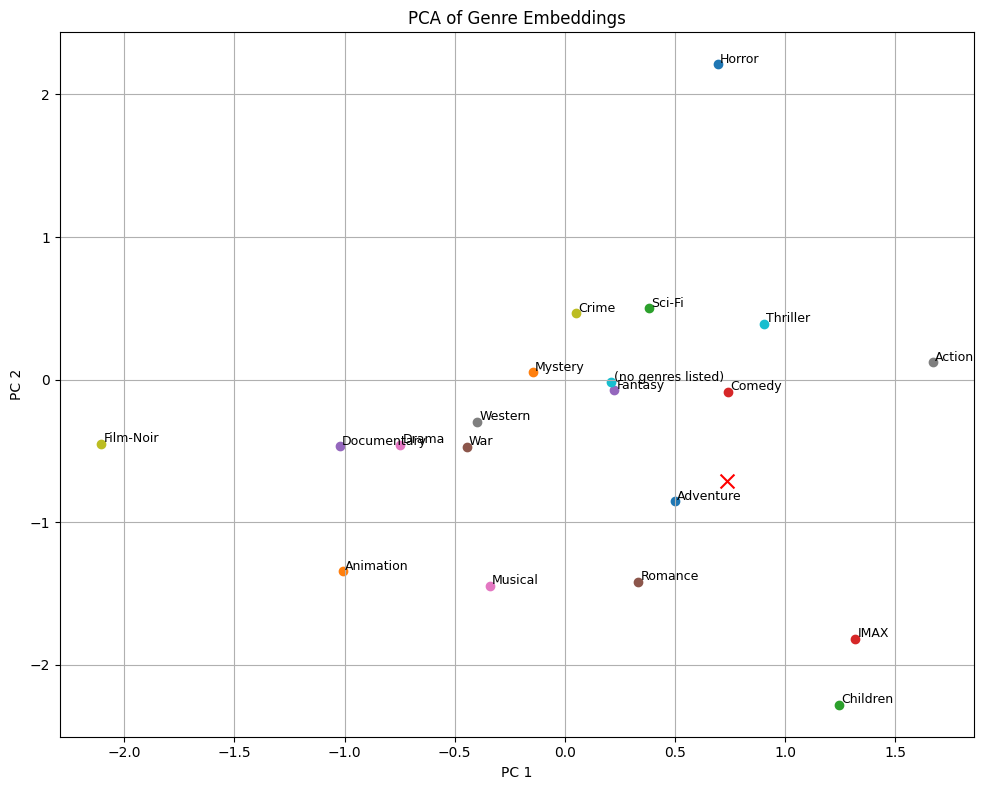

In [71]:
movie_index = movie_to_idx["2116"]

plt.figure(figsize=(10, 8))
for i, coords in enumerate(embeddings[2]):
    genre = idx_to_genre.get(i, f"Genre {i}")
    plt.scatter(coords[0], coords[1], marker='o')
    plt.text(coords[0] + 0.01, coords[1] + 0.01, genre, fontsize=9)

plt.scatter(embeddings[1][movie_index][0], embeddings[1][movie_index][1], color='red', marker='x', s=100, label='Movie 2116')
plt.title("PCA of Genre Embeddings")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)
plt.tight_layout()
plt.show()